<a href="https://colab.research.google.com/github/dlsanf2000/HIR/blob/main/ELMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x 

TensorFlow 1.x selected.


In [2]:
pip install tensorflow-hub


In [3]:
import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K
import urllib.request
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [4]:
elmo = hub.Module("https://tfhub.dev/google/elmo/1", trainable=True)
# 텐서플로우 허브로부터 ELMo를 다운로드

sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
print(keras.__version__)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from math import nan
from keras.callbacks import ModelCheckpoint

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF

# Any results you write to the current directory are saved as output.

2.3.1
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-bd4uz79q
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-bd4uz79q
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=3f6b434e43f56b330a5917832c5aabd79940dfbead893f5f8c54f880619e64df
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqtlqyc4/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
dframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ner.csv', encoding="ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [8]:
dataset=dframe.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word',"pos"],axis=1)

In [9]:
dataset=dataset.drop(['shape'],axis=1)

In [10]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(dataset)

In [12]:
sentences = getter.sentences

In [13]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 140


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

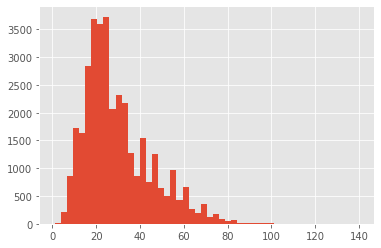

In [15]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [16]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [17]:
n_words = len(words); n_words

30174

In [18]:
tags = list(set(dataset["tag"].values))

In [19]:
n_tags = len(tags); n_tags

18

In [20]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
# idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [21]:
tag2idx

{'B-art': 17,
 'B-eve': 9,
 'B-geo': 8,
 'B-gpe': 15,
 'B-nat': 6,
 'B-org': 0,
 'B-per': 13,
 'B-tim': 12,
 'I-art': 11,
 'I-eve': 5,
 'I-geo': 7,
 'I-gpe': 1,
 'I-nat': 14,
 'I-org': 10,
 'I-per': 3,
 'I-tim': 4,
 'O': 16,
 nan: 2}

In [22]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [23]:
np.array(X).shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(35177,)

In [24]:
X = pad_sequences(maxlen=140, sequences=X, padding="post",value=n_words - 1)

In [25]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [26]:
y = pad_sequences(maxlen=140, sequences=y, padding="post", value=tag2idx["O"])

In [27]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
from keras.models import Model, Input
input = Input(shape=(140,))

In [38]:
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

In [51]:
batch_size = 32

In [45]:
from keras.layers.merge import add

In [58]:
def ElmoEmbedding(x):
    return elmo(inputs={
                            "tokens": tf.squeeze(tf.cast(x, 'string')),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

input_text = Input(shape=(140,))
embedding = Lambda(ElmoEmbedding, output_shape=(max_len, 1024))(input_text)
x = Bidirectional(LSTM(units=100, return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))(embedding)
x_rnn = Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  # residual connection to the first biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [62]:
print(np.array(y_train).shape)
print(X_train.shape)

(28141, 140, 18)
(28141, 140)


In [60]:
model = Model(input_text, out)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
# X_train, X_test = X_train[:1213*batch_size], X_train[-135*batch_size:]
# y_train, y_test = y_train[:1213*batch_size], y_train[-135*batch_size:]
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
# y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

history = model.fit(X_train, np.array(y_train), validation_data=(X_test,np.array(y_test)), 
                 batch_size=batch_size, epochs=3, verbose=1) 

ValueError: ignored